## Modelagem de Dados

INEP Censo Escolar - Taxa de Evasão Escolar

Bibliotecas Utilizadas

```python
# Importação de Dados
import os

# Manipulação de Dados
import pandas as pd

# Visualização
import seaborn as sns
import matplotlib.pyplot as plt

# Modelagem
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# Avaliação do Modelo
from sklearn.metrics import mean_squared_error, r2_score
```

## Montagem do Drive

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
%cd /content/drive/MyDrive/Data Girls/Grace Hopper/entrega_final

/content/drive/MyDrive/Data Girls/Grace Hopper/entrega_final


## Pipeline Completo da Pré-Modelagem

In [34]:
cols_to_drop = ['NU_ANO_CENSO','ALUNOS_TURMA_MED1','ALUNOS_TURMA_MED2','ALUNOS_TURMA_MED3','TAP_MED1','TAP_MED2','TAP_MED3',
                'TRE_MED1','TRE_MED2','TRE_MED3','TAB_MED1','TAB_MED2','TAB_MED3','TEV_MED1','TEV_MED2','TEV_MED3',
                'IN_PARALISADA','QT_MAT_MED_ND','NO_MUNICIPIO','NO_MESORREGIAO','NO_MICRORREGIAO']

cat_cols = ['NO_REGIAO_Centro-Oeste','NO_REGIAO_Nordeste','NO_REGIAO_Norte','NO_REGIAO_Sudeste','NO_REGIAO_Sul',
            'SG_UF_AL','SG_UF_AM','SG_UF_AP','SG_UF_BA','SG_UF_CE','SG_UF_ES','SG_UF_GO','SG_UF_MA','SG_UF_MG',
            'SG_UF_MS','SG_UF_MT','SG_UF_PA','SG_UF_PB','SG_UF_PE','SG_UF_PI','SG_UF_PR','SG_UF_RJ','SG_UF_RN',
            'SG_UF_RO','SG_UF_RR','SG_UF_RS','SG_UF_SE','SG_UF_SP','SG_UF_TO']

In [35]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Treat Dataset
def treat_dataset(df, cols_to_drop):
  """
  Applies primary processing steps on imported dataframe.

  Args:
  df -- Dataset
  cols_to_drop -- List of columns to drop

  Returns:
  df -- Processed dataset
  """
  df = df.dropna()
  df = df.drop(columns=cols_to_drop)
  print('Dataset Imported ✔')

  return df
#---

# 2. Treat Outliers
def treat_outliers(df, target_col):
  """
  Removes outliers from dataset.

  Args:
  df -- Dataset
  target_col -- Target column

  Returns:
  df -- Dataset without outliers
  """
  Q1 = df[target_col].quantile(0.25)
  Q3 = df[target_col].quantile(0.75)
  IQR = Q3 - Q1

  outliers = (df[target_col] < (Q1 - 1.5 * IQR)) | (df[target_col] > (Q3 + 1.5 * IQR))
  print('Outliers Removed  ✔')

  return df[~outliers]
#---

# 3. One-hot Encoding
def hot_encode(df):
  """
  Applies one-hot encoding.

  Args:
  df -- Dataset

  Returns:
  df -- Processed dataset
  """
  df = pd.get_dummies(df, drop_first=True)
  print('One-hot Encoding Applied  ✔')
  return df
#---

# 4. Feature Selection
def select_features(df, target_col):
  """
  Selects the k best features bases on the criteria.

  Args:
  df -- Dataset
  target_col -- Target column

  Returns:
  X_best -- Selected features
  y -- Target column
  selected_cols -- List of selected column names
  """
  X = df.drop(columns=[target_col])
  y = df[target_col]

  selector = SelectKBest(f_regression, k=49)
  X_best = selector.fit_transform(X, y)
  selected_cols = X.columns[selector.get_support()]

  X_best = pd.DataFrame(X_best, columns=selected_cols, index=X.index)
  print('Best Features Selected  ✔')

  return X_best, y, selected_cols
#---

# 5. Split and Scale
def split_scale(X_best, y, cat_cols):
  """
  Splits tha data into training and testing sets.
  Applies feature scaling.

  Args:
  X_best -- Selected features
  y -- Target column
  cat_cols -- List of categorical columns

  Returns:
  X_train, X_test, y_train, y_test -- Splitted data
  """
  X_train, X_test, y_train, y_test = train_test_split(X_best, y, test_size=0.2, random_state=42)

  num_cols = [col for col in X_train.columns if col not in cat_cols]

  scaler = StandardScaler()

  X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
  X_test[num_cols] = scaler.transform(X_test[num_cols])
  print('Split and Scale Applied  ✔')

  return X_train, X_test, y_train, y_test, scaler

In [36]:
def pre_mod_tev(df, target_col='TEV_MED'):
  """
  Applies pre-processing techniques on training dataset.

  Args:
  filepath -- Path to the dataset
  target_col -- Target column

  Returns:
  X_train, X_test, y_train, y_test -- Splitted data
  selected_cols -- List of selected column names
  """

  # 1. Treat Dataset
  df = treat_dataset(df, cols_to_drop)

  # 2. Treat Outliers
  df = treat_outliers(df, target_col)

  # 3. One-hot Encoding
  df = hot_encode(df)

  # 4. Feature Selection
  X_best, y, selected_cols = select_features(df, target_col)

  # 5. Split and Scale
  X_train, X_test, y_train, y_test, scaler = split_scale(X_best, y, cat_cols)

  return X_train, X_test, y_train, y_test, selected_cols, scaler

In [37]:
def pre_mod_notev(df, selected_cols, scaler):
  """
  Applies pre-processing techniques on final dataset.

  Args:
  df -- Dataset
  selected_cols -- List of selected column names
  scaler -- Scaler object

  Returns:
  X -- Processed dataset
  """

  # 1. Treat Dataset
  df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])
  df = df.dropna()

  # 2. One-hot Encoding
  df = pd.get_dummies(df, drop_first=True)

  # Add missing columns with a default value of 0
  for col in selected_cols:
    if col not in df.columns:
      df[col] = 0

  X = df[selected_cols]

  # 3. Scale
  num_cols = [col for col in X.columns if col not in cat_cols]

  X[num_cols] = scaler.transform(X[num_cols])
  return X

## 2019

In [38]:
filepath = os.getcwd() + '/data/processed/municipios_tev_2019.csv'
municipios_tev_2019 = pd.read_csv(filepath, index_col='CO_MUNICIPIO', encoding='latin1')

X_train_19, X_test_19, y_train_19, y_test_19, selected_cols_19, scaler_19 = pre_mod_tev(municipios_tev_2019)

Dataset Imported ✔
Outliers Removed  ✔
One-hot Encoding Applied  ✔
Best Features Selected  ✔
Split and Scale Applied  ✔


### Linear Regression

In [39]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Treino do Modelo
ln_model_19 = LinearRegression()
ln_model_19.fit(X_train_19, y_train_19)

# Previsões
ln_predictions = ln_model_19.predict(X_test_19)

# Avaliação do Modelo
print(f'RMSE: {mean_squared_error(y_test_19,ln_predictions) ** 0.5} \n R²: {r2_score(y_test_19,ln_predictions)}')

RMSE: 0.024584389951381843 
 R²: 0.47821740486261777


### Random Forest Regressor

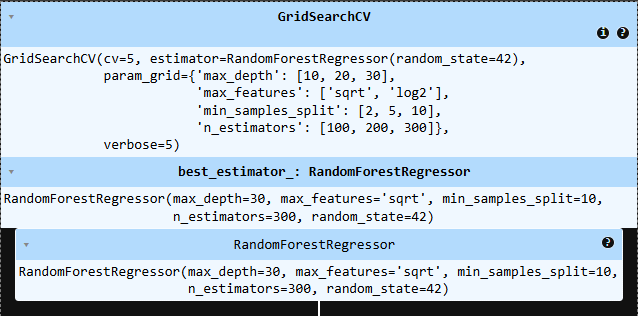

In [40]:
from sklearn.ensemble import RandomForestRegressor

# Treino do Modelo
rf_model_19 = RandomForestRegressor(n_estimators=300, max_depth=30, min_samples_split=10, max_features='sqrt', random_state=42)
rf_model_19.fit(X_train_19, y_train_19)

# Previsões
rf_predictions = rf_model_19.predict(X_test_19)

# Avaliação do Modelo
print(f'RMSE: {mean_squared_error(y_test_19,rf_predictions) ** 0.5} \n R²: {r2_score(y_test_19,rf_predictions)}')

RMSE: 0.023915410358519164 
 R²: 0.5062280774298691


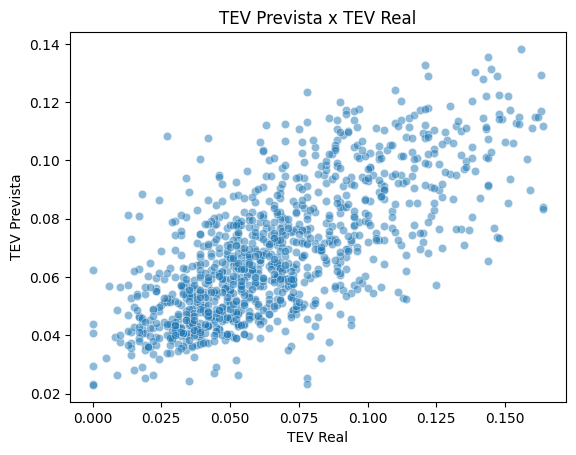

In [41]:
plt.figure()

sns.scatterplot(x=y_test_19, y=rf_predictions, alpha=0.5)

plt.ylabel('TEV Prevista')
plt.xlabel('TEV Real')
plt.title('TEV Prevista x TEV Real')
plt.show()

#### SHAP

100%|===================| 1068/1073 [02:53<00:00]       

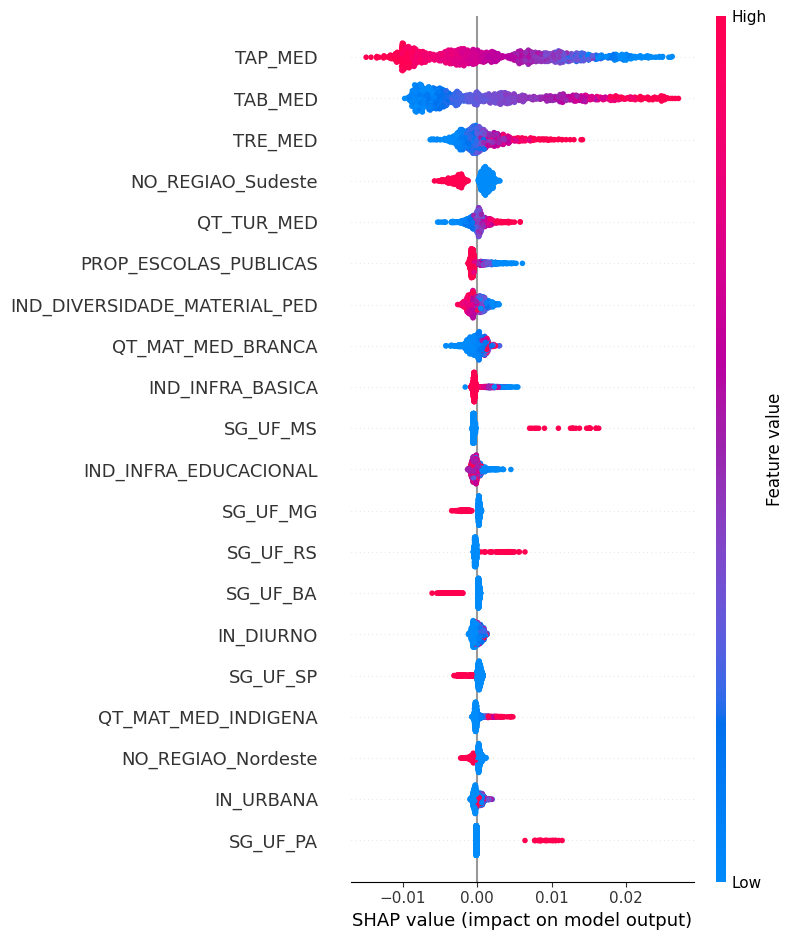

In [42]:
import shap

# SHAP Explanation
explainer = shap.Explainer(rf_model_19, X_train_19, feature_names=selected_cols_19)
shap_values = explainer(X_test_19)

# Generate SHAP summary plot
shap.summary_plot(shap_values, X_test_19, feature_names=selected_cols_19)

O gráfico acima é um resumo visual da importância das variáveis em um modelo de machine learning, com base nos valores SHAP (SHapley Additive exPlanations). Os valores SHAP são uma abordagem baseada na teoria dos jogos para explicar a contribuição de cada variável na predição de um modelo. No gráfico, cada ponto representa uma observação (exemplo) no conjunto de dados, e sua posição no eixo horizontal indica o impacto que aquele valor da variável teve na predição do modelo (positivo ou negativo). A cor do ponto representa o valor da variável: azul para valores baixos e rosa para valores altos.

Para o ano de 2019, as variáveis mais influentes no modelo são `TAP_MED`, `TAB_MED` e `TRE_MED`, cujos valores apresentam maior dispersão nos SHAP values, indicando forte influência nas predições. Por exemplo, valores altos de `TAP_MED` (em rosa) tendem a diminuir a saída do modelo, enquanto valores baixos (em azul) tendem a aumentar a predição, ou seja, uma alta taxa de aprovação reflete em baixa taxa de evasão escolar.

#### Lime

In [43]:
!pip install lime

In [44]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train_19.values,
    feature_names=selected_cols_19,
    mode="regression",
    random_state = 42
)

exp = explainer.explain_instance(X_test_19.iloc[0].values, rf_model_19.predict)
exp.show_in_notebook(show_table=True)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [45]:
data_sum = X_test_19.copy()
data_sum['TEV_MED'] = y_test_19

print(f'Código do Município: {data_sum.index[0]}')
print(f'Valor Real da TEV: {data_sum.iloc[0,-1]}')

Código do Município: 4322350
Valor Real da TEV: 0.034


In [46]:
municipios_tev_2019.loc[data_sum.index[0]]

NO_MUNICIPIO                            União da Serra
NU_ANO_CENSO                                      2019
NO_REGIAO                                          Sul
SG_UF                                               RS
NO_MESORREGIAO                  Nordeste Rio-grandense
NO_MICRORREGIAO                                Guaporé
IN_RURAL                                             0
PROP_ESCOLAS_URBANAS                               1.0
IN_URBANA                                            1
IN_ATIVA                                             1
IN_PARALISADA                                        0
IN_MUNICIPAL                                         0
IN_ESTADUAL                                          1
IN_FEDERAL                                           0
PROP_ESCOLAS_PUBLICAS                              1.0
IN_PRIVADA                                           0
IND_INFRA_BASICA                                   1.0
IND_ACESSIBILIDADE                                 0.0
IND_DIVERSIDADE_MATERIAL_PED                     0.125
IND_INFRA_EDUCACIONAL                         0.666504
IND_INFRA_TEC                                      0.5
IN_ALIMENTACAO                                       1
IN_PROF                                              0
IN_MEDIACAO_PRESENCIAL                               1
IN_MEDIACAO_SEMIPRESENCIAL                           0
IN_MEDIACAO_EAD                                      0
IN_DIURNO                                            1
IN_NOTURNO                                           1
QT_MAT_MED                                          30
QT_MAT_MED_FEM                                    16.0
QT_MAT_MED_MASC                                   14.0
QT_MAT_MED_ND                                      0.0
QT_MAT_MED_BRANCA                                 29.0
QT_MAT_MED_PRETA                                   0.0
QT_MAT_MED_PARDA                                   1.0
QT_MAT_MED_AMARELA                                 0.0
QT_MAT_MED_INDIGENA                                0.0
QT_DOC_MED                                         9.0
QT_TUR_MED                                         3.0
ALUNOS_TURMA_MED                                  10.0
ALUNOS_TURMA_MED1                                 14.0
ALUNOS_TURMA_MED2                                  8.0
ALUNOS_TURMA_MED3                                  8.0
TAP_MED                                          0.966
TAP_MED1                                           1.0
TAP_MED2                                           1.0
TAP_MED3                                         0.875
TRE_MED                                          0.034
TRE_MED1                                           0.0
TRE_MED2                                           0.0
TRE_MED3                                         0.125
TAB_MED                                            0.0
TAB_MED1                                           0.0
TAB_MED2                                           0.0
TAB_MED3                                           0.0
TEV_MED                                          0.034
TEV_MED1                                           0.0
TEV_MED2                                           0.0
TEV_MED3                                         0.125
Name: 4322350, dtype: object

O LIME (Local Interpretable Model-agnostic Explanations) é uma técnica usada para explicar predições individuais de modelos de machine learning de forma interpretável. Ele funciona ao gerar pequenas perturbações nos dados de entrada e observar como o modelo responde a essas variações. Com isso, LIME ajusta um modelo linear simples (como uma regressão linear) ao redor da instância que está sendo explicada, aproximando localmente o comportamento do modelo complexo.

A previsão acima refere-se ao município de código 4322350, União da Serra (RS), localizado na região Sul, na mesorregião Nordeste Rio-grandense e microrregião de Guaporé. Há apenas uma escola ativa de ensino médio no município, e ela pertence à rede estadual. Não há escolas de redes municipal, federal ou privada.

Os indicadores mostram um bom nível de infraestrutura básica (1.0) e de infraestrutura educacional (0.67), além de recursos tecnológicos razoáveis (0.5). Contudo, os índices de acessibilidade (0.0) e diversidade de materiais pedagógicos (0.125) estão significativamente abaixo da média.

A alimentação escolar é garantida na escola, assim como a mediação presencial. As aulas ocorrem tanto no período diurno quanto no noturno.

A taxa média de evasão registrada para o município foi de 3,4%. O valor previsto pelo modelo, a partir das condições observadas, foi de 4%.

## 2020

In [47]:
filepath = os.getcwd() + '/data/processed/municipios_tev_2020.csv'
municipios_tev_2020 = pd.read_csv(filepath, index_col='CO_MUNICIPIO', encoding='latin1')

X_train_20, X_test_20, y_train_20, y_test_20, selected_cols_20, scaler_20 = pre_mod_tev(municipios_tev_2020)

Dataset Imported ✔
Outliers Removed  ✔
One-hot Encoding Applied  ✔
Best Features Selected  ✔
Split and Scale Applied  ✔


### Random Forest Regressor

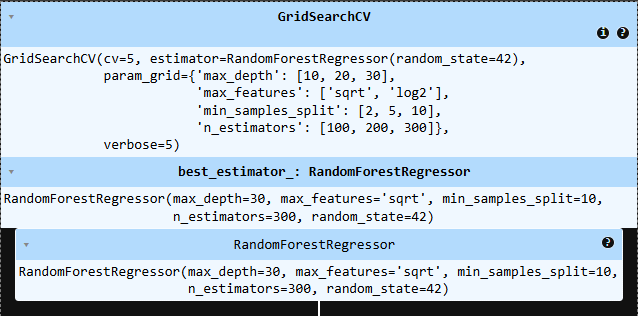

In [48]:
# Treino do Modelo
rf_model_20 = RandomForestRegressor(n_estimators=300, max_depth=30, min_samples_split=10, max_features='sqrt', random_state=42)
rf_model_20.fit(X_train_20, y_train_20)

# Previsões
rf_predictions = rf_model_20.predict(X_test_20)

print(f'RMSE: {mean_squared_error(y_test_20,rf_predictions) ** 0.5} \n R²: {r2_score(y_test_20,rf_predictions)}')

RMSE: 0.03129654064563971 
 R²: 0.46185115759412254


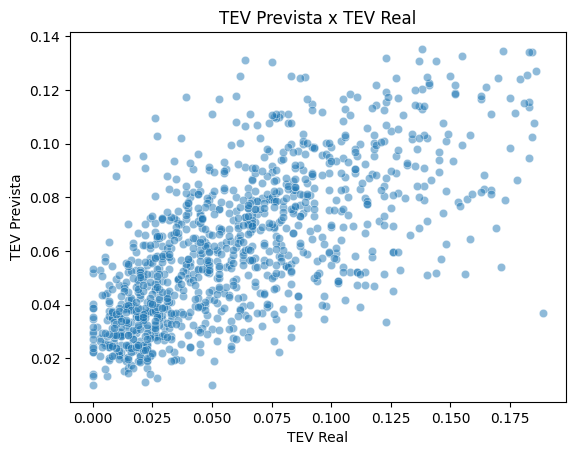

In [49]:
plt.figure()

sns.scatterplot(x=y_test_20, y=rf_predictions, alpha=0.5)

plt.ylabel('TEV Prevista')
plt.xlabel('TEV Real')
plt.title('TEV Prevista x TEV Real')
plt.show()

##### SHAP

100%|===================| 1078/1083 [02:57<00:00]       

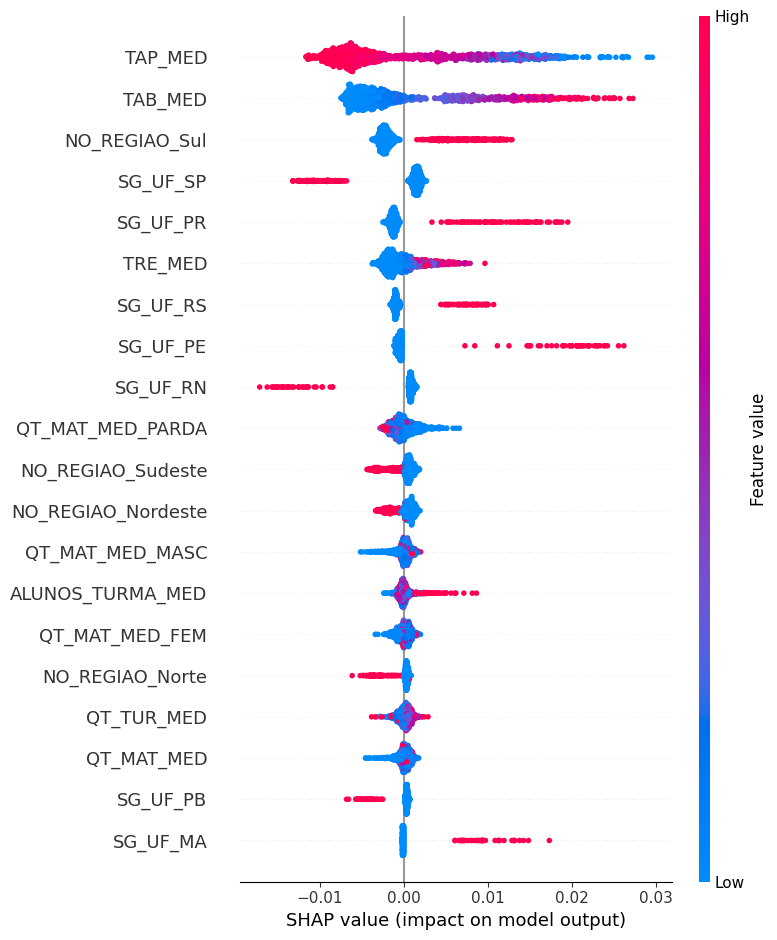

In [50]:
# SHAP Explanation
explainer = shap.Explainer(rf_model_20, X_train_20, feature_names=selected_cols_20)
shap_values = explainer(X_test_20)

# Generate SHAP summary plot
shap.summary_plot(shap_values, X_test_20, feature_names=selected_cols_20)

Para o ano de 2020, as variáveis mais influentes no modelo são `TAP_MED`, `TAB_MED` e `NO_REGIAO_SUL`. Assim como em 2019, valores altos de `TAP_MED` (em rosa) tendem a diminuir a saída do modelo, enquanto valores baixos (em azul) tendem a aumentar a predição, ou seja, uma alta taxa de aprovação reflete em baixa taxa de evasão escolar.

Contudo, a terceira variável, que é binária, indica uma mudança com relação ao ano anterior, fazendo com que "estar na região Sul" aumente a taxa de evasão prevista pelo modelo.

#### Lime

In [51]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train_20.values,
    feature_names=selected_cols_20,
    mode="regression",
    random_state = 42
)

exp = explainer.explain_instance(X_test_20.iloc[0].values, rf_model_20.predict)
exp.show_in_notebook(show_table=True)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [52]:
data_sum = X_test_20.copy()
data_sum['TEV_MED'] = y_test_20

print(f'Código do Município: {data_sum.index[0]}')
print(f'Valor Real da TEV: {data_sum.iloc[0,-1]}')

Código do Município: 1508209
Valor Real da TEV: 0.029


In [53]:
municipios_tev_2020.loc[data_sum.index[0]]

NO_MUNICIPIO                                Vigia
NU_ANO_CENSO                                 2020
NO_REGIAO                                   Norte
SG_UF                                          PA
NO_MESORREGIAO                  Nordeste Paraense
NO_MICRORREGIAO                           Salgado
IN_RURAL                                        4
PROP_ESCOLAS_URBANAS                     0.428571
IN_URBANA                                       3
IN_ATIVA                                        7
IN_PARALISADA                                   0
IN_MUNICIPAL                                    0
IN_ESTADUAL                                     7
IN_FEDERAL                                      0
PROP_ESCOLAS_PUBLICAS                         1.0
IN_PRIVADA                                      0
IND_INFRA_BASICA                         0.971401
IND_ACESSIBILIDADE                           0.25
IND_DIVERSIDADE_MATERIAL_PED             0.107143
IND_INFRA_EDUCACIONAL                    0.476179
IND_INFRA_TEC                            0.285714
IN_ALIMENTACAO                                  7
IN_PROF                                         1
IN_MEDIACAO_PRESENCIAL                          7
IN_MEDIACAO_SEMIPRESENCIAL                      0
IN_MEDIACAO_EAD                                 0
IN_DIURNO                                       7
IN_NOTURNO                                      6
QT_MAT_MED                                   2373
QT_MAT_MED_FEM                             1232.0
QT_MAT_MED_MASC                            1141.0
QT_MAT_MED_ND                               618.0
QT_MAT_MED_BRANCA                           137.0
QT_MAT_MED_PRETA                             12.0
QT_MAT_MED_PARDA                           1599.0
QT_MAT_MED_AMARELA                            5.0
QT_MAT_MED_INDIGENA                           0.0
QT_DOC_MED                                  152.0
QT_TUR_MED                              10.428572
ALUNOS_TURMA_MED                        28.042858
ALUNOS_TURMA_MED1                       30.014286
ALUNOS_TURMA_MED2                       29.085714
ALUNOS_TURMA_MED3                       27.042856
TAP_MED                                       1.0
TAP_MED1                                      1.0
TAP_MED2                                      1.0
TAP_MED3                                      1.0
TRE_MED                                       0.0
TRE_MED1                                      0.0
TRE_MED2                                      0.0
TRE_MED3                                      0.0
TAB_MED                                       0.0
TAB_MED1                                      0.0
TAB_MED2                                      0.0
TAB_MED3                                      0.0
TEV_MED                                     0.029
TEV_MED1                                    0.043
TEV_MED2                                    0.043
TEV_MED3                                      0.0
Name: 1508209, dtype: object

A previsão acima refere-se ao município de código 1508209, Vigia (PA), localizado na região Norte, na mesorregião Nordeste Paraense e microrregião de Salgado. Há 7 escolas ativas de ensino médio, todas pertencentes à rede estadual. Não há escolas municipais, federais ou privadas.

Cerca de 43% das escolas estão localizadas em áreas urbanas, enquanto a maioria está em zonas rurais. Os indicadores revelam bons níveis de infraestrutura básica (0,97), mas os índices de acessibilidade (0,25), diversidade de materiais pedagógicos (0,11), infraestrutura educacional (0,48) e tecnológica (0,29) estão abaixo da média.

A alimentação escolar é oferecida em todas as unidades, e a mediação é inteiramente presencial. As aulas ocorrem predominantemente durante o dia, embora 6 das 7 escolas também ofereçam ensino noturno.

A taxa média de evasão registrada foi de 2,9%. O valor previsto pelo modelo, com base nas condições observadas, foi de 3%.

## 2021

In [54]:
filepath = os.getcwd() + '/data/processed/municipios_2021.csv'
municipios_2021 = pd.read_csv(filepath, index_col='CO_MUNICIPIO', encoding='latin1')

#### Modelo 2019

In [55]:
X_21 = pre_mod_notev(municipios_2021, selected_cols_19, scaler_19)
y_pred_21_m19 = rf_model_19.predict(X_21)

/tmp/ipython-input-2210479039.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[num_cols] = scaler.transform(X[num_cols])


In [56]:
municipios_tev_2021_m19 = municipios_2021.copy()
municipios_tev_2021_m19['TEV_MED'] = y_pred_21_m19

municipios_tev_2021_m19.head()

NO_MUNICIPIO  NU_ANO_CENSO NO_REGIAO SG_UF  \
CO_MUNICIPIO                                                        
1100015       Alta Floresta D'Oeste          2021     Norte    RO   
1100023                   Ariquemes          2021     Norte    RO   
1100031                      Cabixi          2021     Norte    RO   
1100049                      Cacoal          2021     Norte    RO   
1100056                  Cerejeiras          2021     Norte    RO   

                 NO_MESORREGIAO    NO_MICRORREGIAO  IN_RURAL  \
CO_MUNICIPIO                                                   
1100015       Leste Rondoniense             Cacoal         3   
1100023       Leste Rondoniense          Ariquemes         2   
1100031       Leste Rondoniense  Colorado do Oeste         1   
1100049       Leste Rondoniense             Cacoal         6   
1100056       Leste Rondoniense  Colorado do Oeste         1   

              PROP_ESCOLAS_URBANAS  IN_URBANA  IN_ATIVA  ...  TAP_MED3  \
CO_MUNICIPIO                                             ...             
1100015                   0.500000          3         6  ...  0.943333   
1100023                   0.777778          7         9  ...  0.911444   
1100031                   0.500000          1         2  ...  0.944500   
1100049                   0.684211         13        19  ...  0.737632   
1100056                   0.500000          1         2  ...  0.422500   

               TRE_MED  TRE_MED1  TRE_MED2  TRE_MED3   TAB_MED  TAB_MED1  \
CO_MUNICIPIO                                                               
1100015       0.166667  0.202833  0.190167  0.049000  0.007000  0.007500   
1100023       0.086222  0.121667  0.087444  0.057889  0.045667  0.045556   
1100031       0.000000  0.000000  0.000000  0.000000  0.041000  0.024500   
1100049       0.032632  0.044053  0.024632  0.010053  0.050737  0.031789   
1100056       0.038500  0.034000  0.049500  0.034000  0.097500  0.091000   

              TAB_MED2  TAB_MED3   TEV_MED  
CO_MUNICIPIO                                
1100015       0.005833  0.007667  0.087706  
1100023       0.053778  0.030667  0.081527  
1100031       0.016500  0.055500  0.057685  
1100049       0.034368  0.094421  0.074666  
1100056       0.056000  0.043500  0.098982  

[5 rows x 56 columns]

#### Modelo 2020

In [57]:
X_21 = pre_mod_notev(municipios_2021, selected_cols_20, scaler_20)

# Applying model
y_pred_21_m20 = rf_model_20.predict(X_21)

/tmp/ipython-input-2210479039.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[num_cols] = scaler.transform(X[num_cols])


In [58]:
municipios_tev_2021_m20 = municipios_2021.copy()
municipios_tev_2021_m20['TEV_MED'] = y_pred_21_m20

municipios_tev_2021_m20.head()

NO_MUNICIPIO  NU_ANO_CENSO NO_REGIAO SG_UF  \
CO_MUNICIPIO                                                        
1100015       Alta Floresta D'Oeste          2021     Norte    RO   
1100023                   Ariquemes          2021     Norte    RO   
1100031                      Cabixi          2021     Norte    RO   
1100049                      Cacoal          2021     Norte    RO   
1100056                  Cerejeiras          2021     Norte    RO   

                 NO_MESORREGIAO    NO_MICRORREGIAO  IN_RURAL  \
CO_MUNICIPIO                                                   
1100015       Leste Rondoniense             Cacoal         3   
1100023       Leste Rondoniense          Ariquemes         2   
1100031       Leste Rondoniense  Colorado do Oeste         1   
1100049       Leste Rondoniense             Cacoal         6   
1100056       Leste Rondoniense  Colorado do Oeste         1   

              PROP_ESCOLAS_URBANAS  IN_URBANA  IN_ATIVA  ...  TAP_MED3  \
CO_MUNICIPIO                                             ...             
1100015                   0.500000          3         6  ...  0.943333   
1100023                   0.777778          7         9  ...  0.911444   
1100031                   0.500000          1         2  ...  0.944500   
1100049                   0.684211         13        19  ...  0.737632   
1100056                   0.500000          1         2  ...  0.422500   

               TRE_MED  TRE_MED1  TRE_MED2  TRE_MED3   TAB_MED  TAB_MED1  \
CO_MUNICIPIO                                                               
1100015       0.166667  0.202833  0.190167  0.049000  0.007000  0.007500   
1100023       0.086222  0.121667  0.087444  0.057889  0.045667  0.045556   
1100031       0.000000  0.000000  0.000000  0.000000  0.041000  0.024500   
1100049       0.032632  0.044053  0.024632  0.010053  0.050737  0.031789   
1100056       0.038500  0.034000  0.049500  0.034000  0.097500  0.091000   

              TAB_MED2  TAB_MED3   TEV_MED  
CO_MUNICIPIO                                
1100015       0.005833  0.007667  0.055135  
1100023       0.053778  0.030667  0.060236  
1100031       0.016500  0.055500  0.061602  
1100049       0.034368  0.094421  0.055455  
1100056       0.056000  0.043500  0.071985  

[5 rows x 56 columns]

### Análise da Diferença entre os Resultados

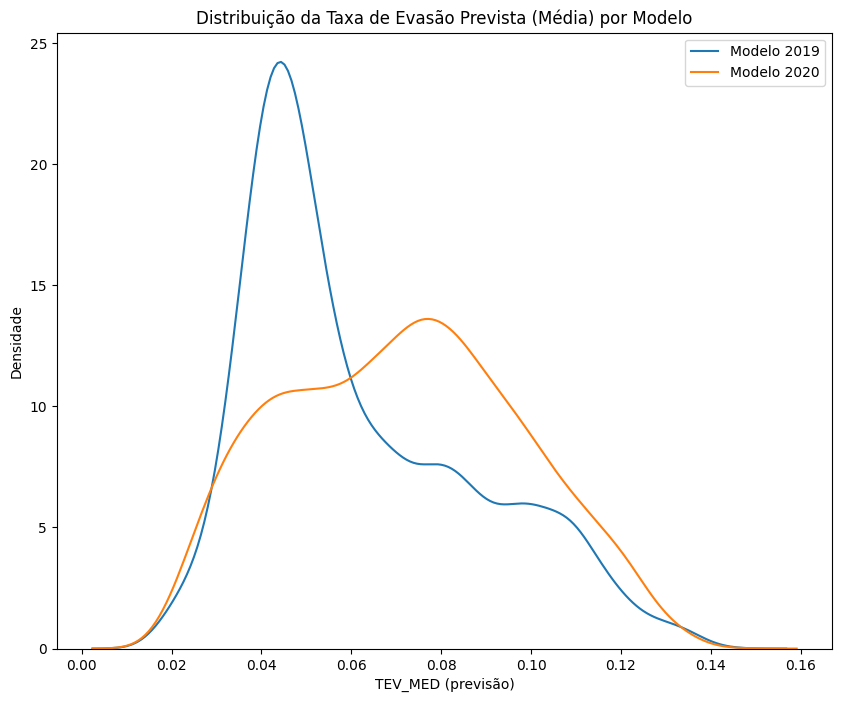

In [59]:
plt.figure(figsize=(10, 8))

sns.kdeplot(municipios_tev_2021_m19['TEV_MED'], label='Modelo 2019')
sns.kdeplot(municipios_tev_2021_m20['TEV_MED'], label='Modelo 2020')

plt.title('Distribuição da Taxa de Evasão Prevista (Média) por Modelo')
plt.xlabel('TEV_MED (previsão)')
plt.ylabel('Densidade')
plt.legend()
plt.show()

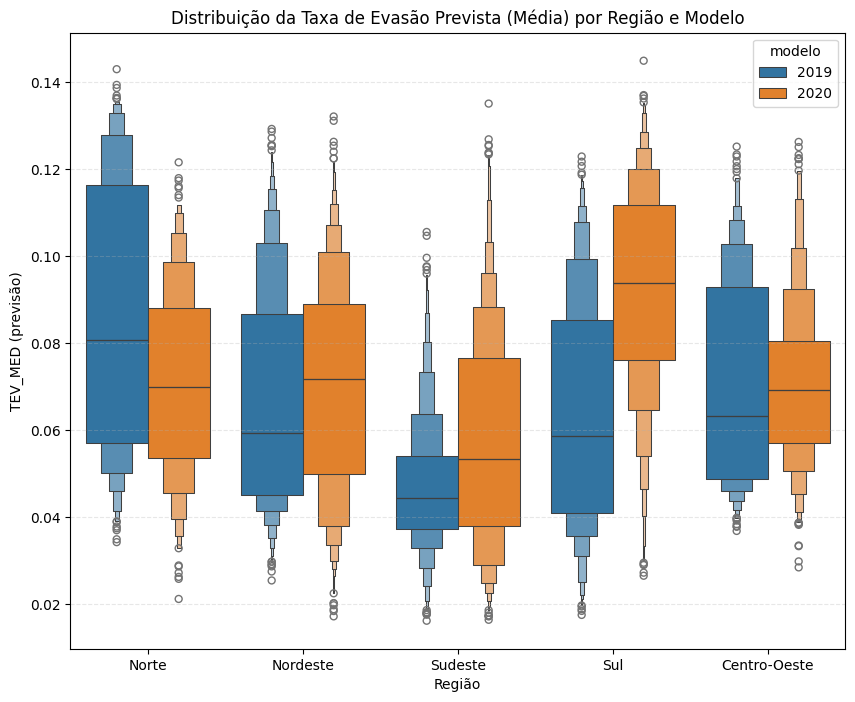

In [60]:
df_comparado = pd.concat([
  municipios_tev_2021_m19[['NO_REGIAO', 'TEV_MED']].assign(modelo='2019'),
  municipios_tev_2021_m20[['NO_REGIAO', 'TEV_MED']].assign(modelo='2020')
])

plt.figure(figsize=(10, 8))
sns.boxenplot(data=df_comparado, x='NO_REGIAO', y='TEV_MED', hue='modelo')
plt.title('Distribuição da Taxa de Evasão Prevista (Média) por Região e Modelo')
plt.ylabel('TEV_MED (previsão)')
plt.xlabel('Região')
plt.grid(True, axis='y', linestyle='--', alpha=0.3)
plt.show()

### Previsão Final

In [61]:
municipios_tev_2021 = municipios_2021.copy()
municipios_tev_2021['TEV_MED'] = (y_pred_21_m19 + y_pred_21_m20) / 2

municipios_tev_2021.head()

NO_MUNICIPIO  NU_ANO_CENSO NO_REGIAO SG_UF  \
CO_MUNICIPIO                                                        
1100015       Alta Floresta D'Oeste          2021     Norte    RO   
1100023                   Ariquemes          2021     Norte    RO   
1100031                      Cabixi          2021     Norte    RO   
1100049                      Cacoal          2021     Norte    RO   
1100056                  Cerejeiras          2021     Norte    RO   

                 NO_MESORREGIAO    NO_MICRORREGIAO  IN_RURAL  \
CO_MUNICIPIO                                                   
1100015       Leste Rondoniense             Cacoal         3   
1100023       Leste Rondoniense          Ariquemes         2   
1100031       Leste Rondoniense  Colorado do Oeste         1   
1100049       Leste Rondoniense             Cacoal         6   
1100056       Leste Rondoniense  Colorado do Oeste         1   

              PROP_ESCOLAS_URBANAS  IN_URBANA  IN_ATIVA  ...  TAP_MED3  \
CO_MUNICIPIO                                             ...             
1100015                   0.500000          3         6  ...  0.943333   
1100023                   0.777778          7         9  ...  0.911444   
1100031                   0.500000          1         2  ...  0.944500   
1100049                   0.684211         13        19  ...  0.737632   
1100056                   0.500000          1         2  ...  0.422500   

               TRE_MED  TRE_MED1  TRE_MED2  TRE_MED3   TAB_MED  TAB_MED1  \
CO_MUNICIPIO                                                               
1100015       0.166667  0.202833  0.190167  0.049000  0.007000  0.007500   
1100023       0.086222  0.121667  0.087444  0.057889  0.045667  0.045556   
1100031       0.000000  0.000000  0.000000  0.000000  0.041000  0.024500   
1100049       0.032632  0.044053  0.024632  0.010053  0.050737  0.031789   
1100056       0.038500  0.034000  0.049500  0.034000  0.097500  0.091000   

              TAB_MED2  TAB_MED3   TEV_MED  
CO_MUNICIPIO                                
1100015       0.005833  0.007667  0.071420  
1100023       0.053778  0.030667  0.070881  
1100031       0.016500  0.055500  0.059643  
1100049       0.034368  0.094421  0.065060  
1100056       0.056000  0.043500  0.085484  

[5 rows x 56 columns]

In [63]:
import json
import requests
import plotly.express as px

# Baixar o GeoJSON de estados do Brasil (IBGE)
url = "https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson"
response = requests.get(url)
geojson = response.json()

fig = px.choropleth(
   municipios_tev_2021,
   locations='SG_UF',
   color='TEV_MED',
   hover_name='SG_UF',
   scope='south america',
   featureidkey='properties.sigla',
   geojson=geojson,
   color_continuous_scale='Reds'
)

fig.update_geos(fitbounds='locations', visible=False)
fig.update_layout(
  title_text='Taxa de Evasão Média Prevista 2021',
  margin={"r":0,"t":50,"l":0,"b":0},
  height=800
)
fig.show()

In [ ]:
#municipios_tev_2021.to_csv(os.getcwd() + '/data/processed/municipios_tev_2021.csv', index=True)